## 1. Data Wrangling<a id='1._Data Wrangling'></a>

In [1]:
# importing relevant packages
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from datetime import datetime
import time

In [2]:
df_login = pd.read_json('logins.json')


In [3]:
df_login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df_login.isnull().sum()

login_time    0
dtype: int64

In [5]:
df_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
min_time=df_login.min()
max_time=df_login.max()
print("Earliest",min_time)
print("Latest",  max_time)

Earliest login_time   1970-01-01 20:12:16
dtype: datetime64[ns]
Latest login_time   1970-04-13 18:57:38
dtype: datetime64[ns]


In [7]:
df_login=df_login.sort_values(by="login_time")
df_login.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [8]:
df_login['count']=1
df_login.set_index(["login_time"], inplace = True)
df_login.head()

,count
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1


## 2. Exploratory Data analysis<a id='2._Exploratory Data analysis'></a>

In [9]:
df_bin=df_login['count'].resample('15T').count()
df_bin.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, Name: count, dtype: int64

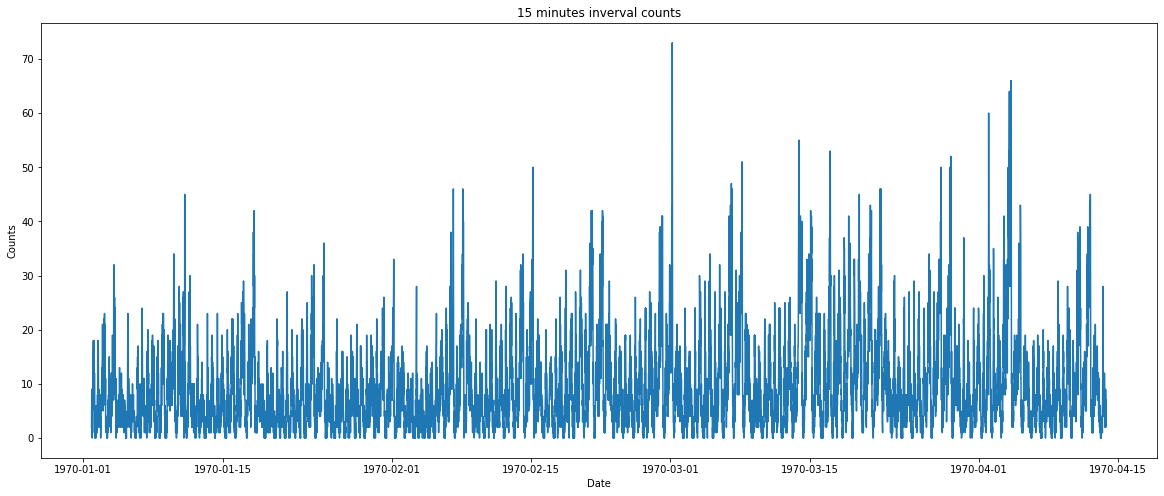

In [10]:
plt.figure(figsize=(20,8))
plt.plot(df_bin)
plt.title('15 minutes inverval counts')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.show()

login_time
1970-01-01 20:00:00    24
1970-01-01 21:00:00     9
1970-01-01 22:00:00    21
1970-01-01 23:00:00    58
1970-01-02 00:00:00    53
Freq: H, Name: count, dtype: int64


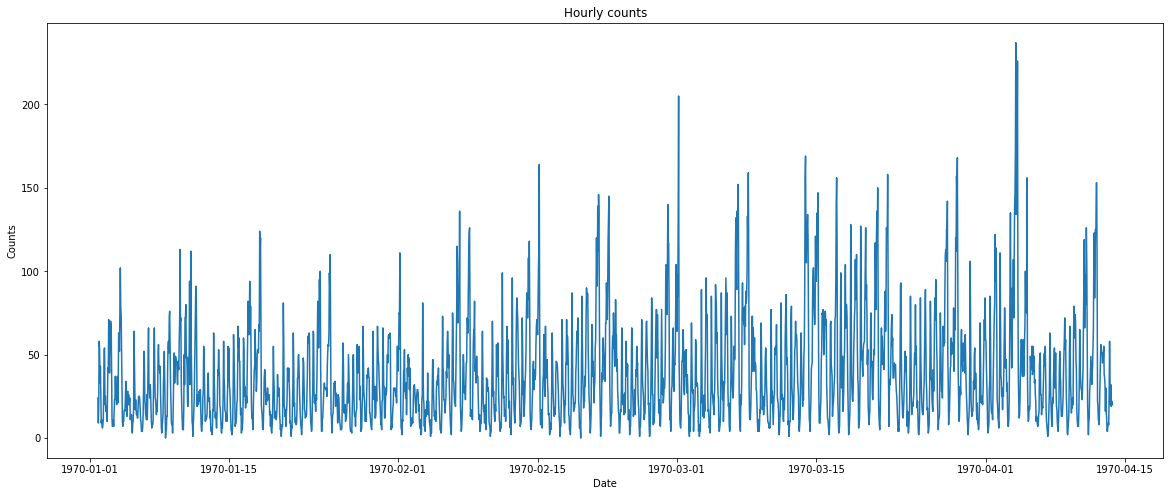

In [11]:
df_bin=df_login['count'].resample('H').count()
print(df_bin.head())
plt.figure(figsize=(20,8))
plt.plot(df_bin)
plt.title('Hourly counts')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.show()

login_time
1970-01-01    112
1970-01-02    681
1970-01-03    793
1970-01-04    788
1970-01-05    459
Freq: D, Name: count, dtype: int64


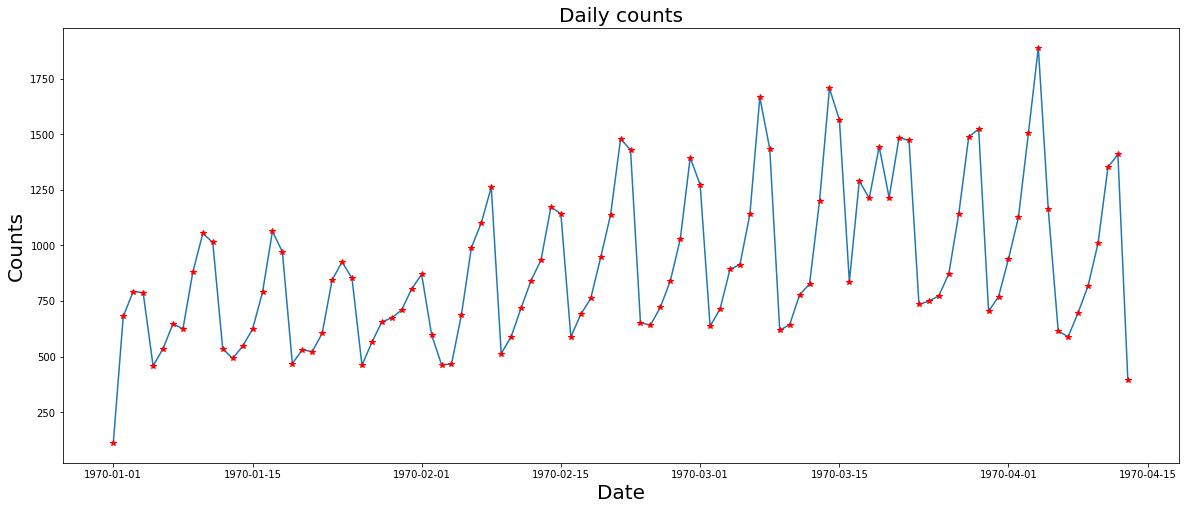

In [12]:
df_bin=df_login['count'].resample('D').count()
print(df_bin.head())
plt.figure(figsize=(20,8))
plt.plot(df_bin)
plt.plot(df_bin,'r*')
plt.title('Daily counts',fontsize='20')
plt.xlabel('Date',fontsize='20')
plt.ylabel('Counts',fontsize='20')
plt.show()

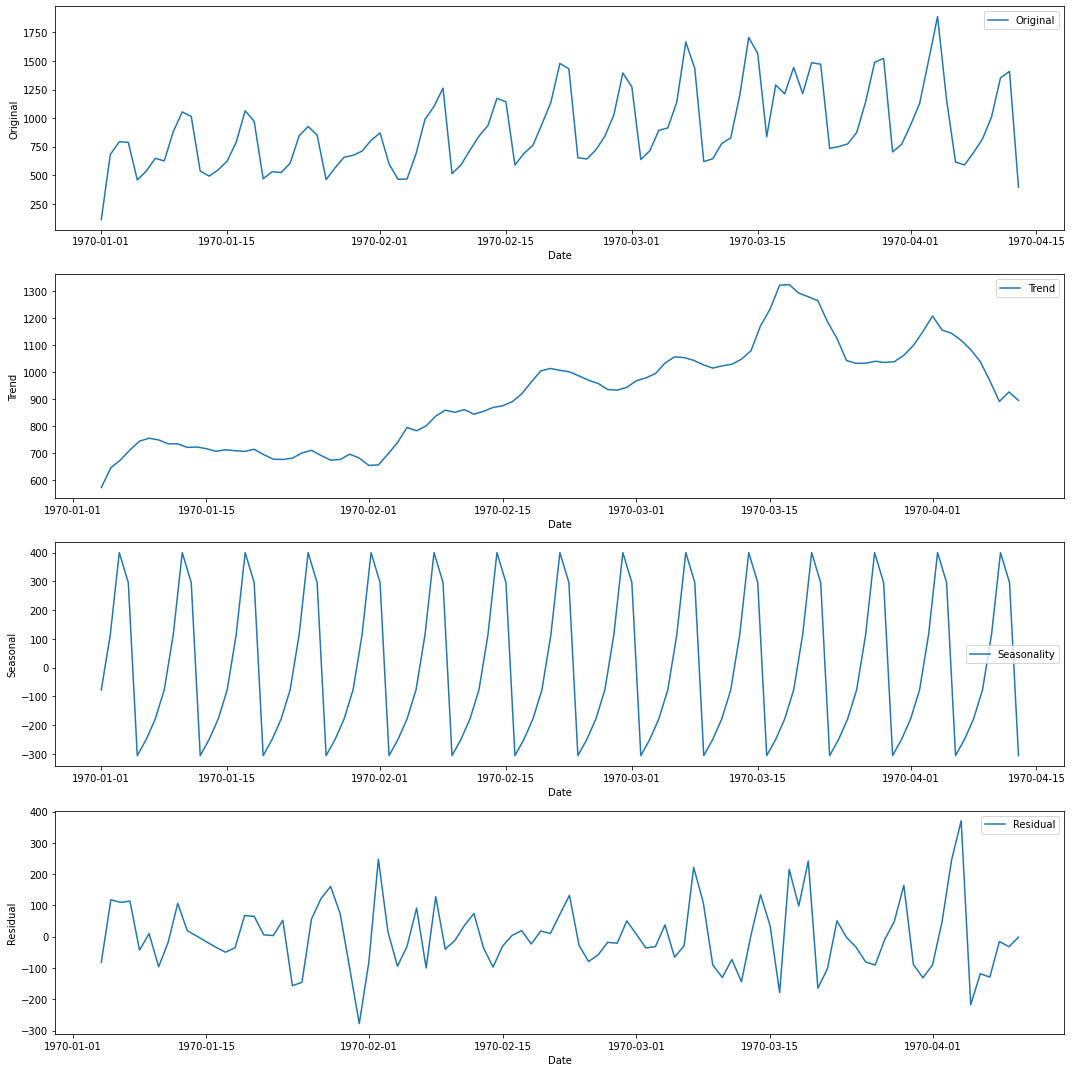

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

y=df_bin
decomposition= seasonal_decompose(y,model='additive')


# Plot the original data, the trend, the seasonality, and the residuals 
original=decomposition.observed
trend=decomposition.trend 
seasonality=decomposition.seasonal 

residual=decomposition.resid

f, axs = plt.subplots(4,1,figsize=(15,15))
plt.subplot(411)
plt.plot(original,label='Original')
plt.xlabel('Date')
plt.ylabel('Original')
plt.legend(loc = 'best')
plt.tight_layout()

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend(loc = 'best')
plt.tight_layout()

plt.subplot(413)
plt.plot(seasonality,label='Seasonality')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.legend(loc = 'best')
plt.tight_layout()

plt.subplot(414)
plt.plot(residual,label='Residual')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend(loc = 'best')
plt.tight_layout()

## 3. Checking data stationary<a id='3._Checking data stationary'></a>


In [14]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series):
    #result=adfuller(series, maxlag=7,regression='c', autolag='AIC')
    result=adfuller(series,regression='c', autolag='AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(y)

ADF Test Statistic : -1.403316491921988
p-value : 0.5806851218557992
#Lags Used : 13
Number of Observations : 89
weak evidence against null hypothesis,indicating it is non-stationary 


In [15]:
results = adfuller(y)
print(results)

(-1.403316491921988, 0.5806851218557992, 13, 89, {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}, 1173.2398848029677)


In [16]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings('ignore')
#def kpss_test(series, **kw):    
#    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, regression='c', nlags="auto")
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(y)

KPSS Statistic: 1.335974728525808
p-value: 0.01
num lags: 4
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


## 4. Making the data  stationary <a id='4._Making the data  stationary'></a>

## 4.1 Data differencing <a id='4.1_Data differencing'></a>

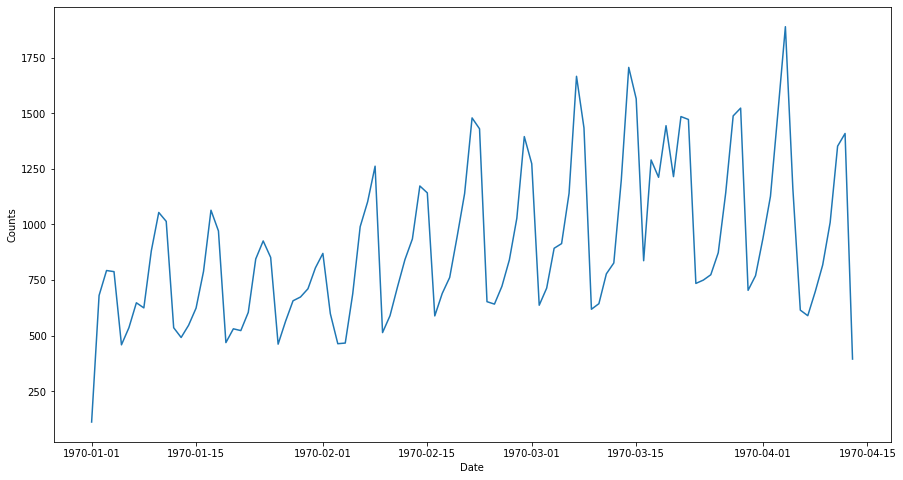

In [17]:
plt.figure(figsize=(15,8))
plt.plot(y)
plt.ylabel('Counts')
plt.xlabel('Date')
plt.show()

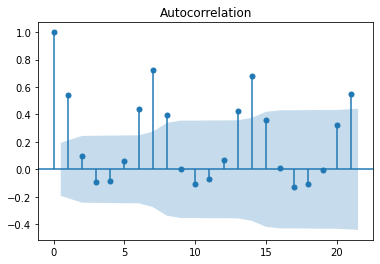

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y)
plt.show()

In [19]:
for i in range(1,20):
    print("autocorrelation for lag %d is %.3f" %(i, y.diff(i).autocorr()))

autocorrelation for lag 1 is 0.089
autocorrelation for lag 2 is 0.370
autocorrelation for lag 3 is 0.516
autocorrelation for lag 4 is 0.536
autocorrelation for lag 5 is 0.420
autocorrelation for lag 6 is 0.296
autocorrelation for lag 7 is 0.572
autocorrelation for lag 8 is 0.337
autocorrelation for lag 9 is 0.420
autocorrelation for lag 10 is 0.520
autocorrelation for lag 11 is 0.521
autocorrelation for lag 12 is 0.386
autocorrelation for lag 13 is 0.221
autocorrelation for lag 14 is 0.533
autocorrelation for lag 15 is 0.271
autocorrelation for lag 16 is 0.417
autocorrelation for lag 17 is 0.515
autocorrelation for lag 18 is 0.549
autocorrelation for lag 19 is 0.424


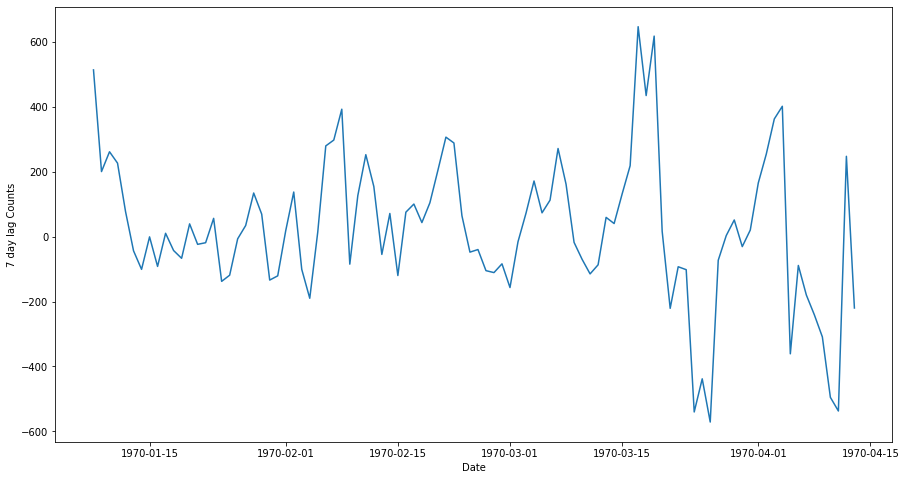

In [20]:
plt.figure(figsize=(15,8))
plt.plot(y.diff(7).dropna())
plt.ylabel('7 day lag Counts')
plt.xlabel('Date')
plt.show()

In [21]:
lag=7
adfuller_test(y.diff(lag).dropna())

ADF Test Statistic : -2.456809845914013
p-value : 0.12633962047322744
#Lags Used : 9
Number of Observations : 86
weak evidence against null hypothesis,indicating it is non-stationary 


In [22]:
lag=7
results = adfuller(y.diff(lag).dropna())
print(results)

(-2.456809845914013, 0.12633962047322744, 9, 86, {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}, 1083.6674436759913)


In [23]:
#from statsmodels.graphics.tsaplots import plot_acf
#plot_acf(y.diff(7).dropna())
#plt.show()

## 4.2 Log transformation <a id='4.2_Log transformation'></a>

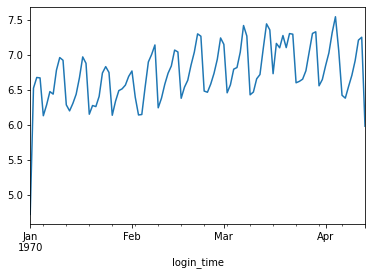

In [24]:
logy=np.log(y)
logy.plot()
plt.show()

In [25]:
adfuller_test(logy)

ADF Test Statistic : -1.6379910499675847
p-value : 0.4633107194019364
#Lags Used : 13
Number of Observations : 89
weak evidence against null hypothesis,indicating it is non-stationary 


In [26]:
adfuller_test(logy.diff().dropna())

ADF Test Statistic : -4.785755130794884
p-value : 5.7903124091723575e-05
#Lags Used : 13
Number of Observations : 88
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [27]:
kpss_test(logy.diff().dropna())

KPSS Statistic: 0.3506391630435012
p-value: 0.09843139523987017
num lags: 5
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


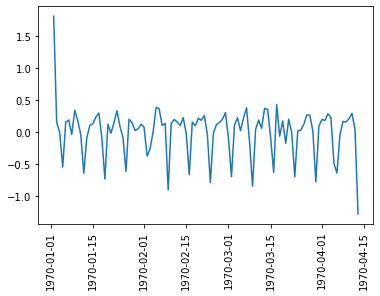

In [28]:
plt.plot(logy.diff().dropna())
plt.xticks(rotation=90)
plt.show()


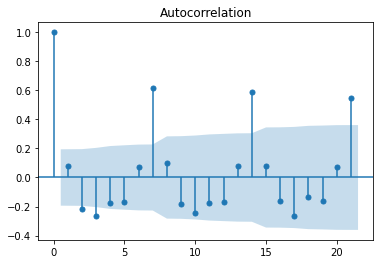

In [29]:
plot_acf(logy.diff().dropna())
plt.show()

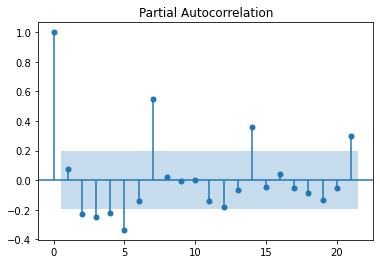

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(logy.diff().dropna())
plt.show()

## 4.3 The Arima model <a id='4.3_The Arima model'></a>

In [31]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [32]:
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train,test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [33]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

In [34]:
p_values = [x for x in range(0, 8)]
d_values = [x for x in range(0, 2)]
q_values = [x for x in range(0, 8)]

In [35]:
evaluate_models(logy, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.1686508
ARIMA(0, 0, 1) MSE=0.1144019
ARIMA(0, 0, 2) MSE=0.1142052
ARIMA(0, 0, 3) MSE=0.1118217
ARIMA(0, 0, 4) MSE=0.1125547
ARIMA(0, 0, 5) MSE=0.1245107
ARIMA(0, 0, 6) MSE=0.1023685
ARIMA(0, 0, 7) MSE=0.1216473
ARIMA(0, 1, 0) MSE=0.1656698
ARIMA(0, 1, 1) MSE=0.1593210
ARIMA(0, 1, 2) MSE=0.1401701
ARIMA(0, 1, 3) MSE=0.1298357
ARIMA(0, 1, 4) MSE=0.1502054
ARIMA(0, 1, 5) MSE=0.1603580
ARIMA(0, 1, 6) MSE=0.1539850
ARIMA(0, 1, 7) MSE=0.1054637
ARIMA(1, 0, 0) MSE=0.1356188
ARIMA(1, 0, 1) MSE=0.1182234
ARIMA(1, 0, 2) MSE=0.1144190
ARIMA(1, 0, 3) MSE=0.1122982
ARIMA(1, 0, 4) MSE=0.1084840
ARIMA(1, 0, 5) MSE=0.1352785
ARIMA(1, 0, 6) MSE=0.1379444
ARIMA(1, 0, 7) MSE=0.1601055
ARIMA(1, 1, 0) MSE=0.1627248
ARIMA(1, 1, 1) MSE=0.1935338
ARIMA(1, 1, 2) MSE=0.1387744
ARIMA(1, 1, 3) MSE=0.1324569
ARIMA(1, 1, 4) MSE=0.1666917
ARIMA(1, 1, 5) MSE=0.2030795
ARIMA(1, 1, 6) MSE=0.1808708
ARIMA(2, 0, 0) MSE=0.1124683
ARIMA(2, 0, 1) MSE=0.1124718
ARIMA(2, 0, 2) MSE=0.1109878
ARIMA(2, 0, 3)

In [36]:
#Although (3, 0, 3 ) is indicated best, data is not stationary without d=1 on logy. The next minimum MSE is with ARIMA(5, 1, 2) MSE=0.0638270
#which makes sense based on ACF and PACF plot

p=5
d=1
q=2
model = ARIMA(logy, order=(p,d,q))
model_fit = model.fit()



In [37]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.count   No. Observations:                  102
Model:                 ARIMA(5, 1, 2)   Log Likelihood                 -20.008
Method:                       css-mle   S.D. of innovations              0.250
Date:                Tue, 25 May 2021   AIC                             58.016
Time:                        21:07:20   BIC                             81.641
Sample:                    01-02-1970   HQIC                            67.583
                         - 04-13-1970                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0058        nan        nan        nan         nan         nan
ar.L1.D.count     0.4866   2.26e-06   2.15e+05      0.000       0.487       0.487
ar.L2.D.count    -0.7993        nan        nan        nan         nan         nan
ar.L3.D.count    -0.0624        nan        nan        nan         nan         nan
ar.L4.D.count    -0.4608   1.06e-06  -4.33e+05      0.000      -0.461      -0.461
ar.L5.D.count    -0.2225   1.22e-06  -1.83e+05      0.000      -0.223      -0.223
ma.L1.D.count    -1.1023        nan        nan        nan         nan         nan
ma.L2.D.count     0.8444        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6209           -0.7839j            1.0000           -0.1434
AR.2            0.6209           +0.7839j            1.0000            0.1434
AR.3           -0.3203           -1.2568j            1.2970           -0.2897
AR.4           -0.3203           +1.2568j            1.2970            0.2897
AR.5           -2.6718           -0.0000j            2.6718           -0.5000
MA.1            0.6527           -0.8708j            1.0882           -0.1476
MA.2            0.6527           +0.8708j            1.0882            0.1476
-----------------------------------------------------------------------------
"""

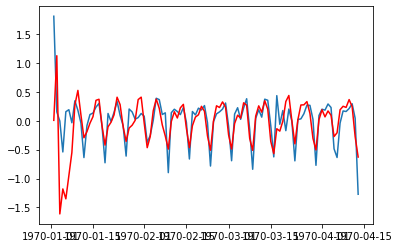

In [38]:
plt.plot(figsize=(15,10))
plt.plot(logy.diff())
plt.plot(model_fit.predict(), color = 'red')
plt.show()

## 5. Model forecasting <a id='5._Model forecasting'></a>

In [40]:
forecast_period = 10
forecast = model_fit.forecast(10)

In [41]:
# Declare a variable called forecast_period with the amount of days to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast


date_range = pd.date_range(logy.index[-1], periods = forecast_period, 
              freq='D').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_days = pd.DataFrame(date_range, columns = ['login_time'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_days['login_time'] = pd.to_datetime(future_days['login_time'])
print(future_days)
future_days.set_index('login_time', inplace = True)
future_days['Prediction'] = forecast[0]



  login_time
0 1970-04-13
1 1970-04-14
2 1970-04-15
3 1970-04-16
4 1970-04-17
5 1970-04-18
6 1970-04-19
7 1970-04-20
8 1970-04-21
9 1970-04-22


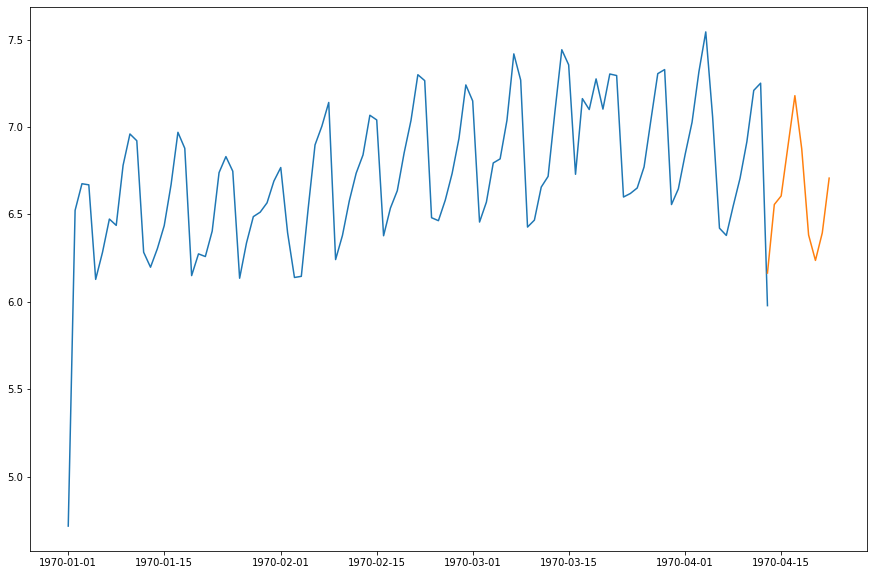

In [42]:
# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(logy)
plt.plot((future_days['Prediction']))
plt.show()

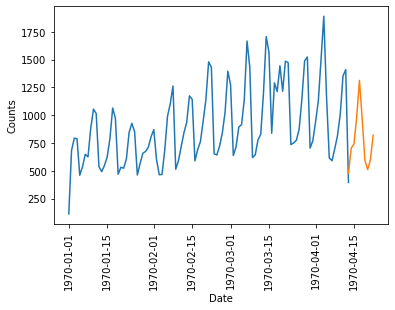

In [43]:
plt.plot(figsize=(50,10))
plt.plot(y)
plt.plot(np.exp((future_days['Prediction'])))
plt.ylabel('Counts')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()